<a href="https://colab.research.google.com/github/tinayiluo0322/ECE_Final_Project_2025/blob/main/ASR_Adversarial_Patch_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Patch Attack

## Load Data from CIFAR

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.5

# convert data to a normalized torch.FloatTensor
print('==> Preparing data..')
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# # choose the training and test datasets
# train_data = datasets.CIFAR10('data', train=True,
#                               download=True, transform=transform_train)
# test_data = datasets.CIFAR10('data', train=False,
#                              download=True, transform=transform_test)

# # obtain training indices that will be used for validation
# num_train = len(train_data)
# indices = list(range(num_train))
# np.random.shuffle(indices)
# split = int(np.floor(valid_size * num_train))
# train_idx, valid_idx = indices[split:], indices[:split]

# # define samplers for obtaining training and validation batches
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

# # prepare data loaders (combine dataset and sampler)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#     sampler=train_sampler, num_workers=num_workers)
# valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#     sampler=valid_sampler, num_workers=num_workers)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
#     num_workers=num_workers)

# valid_size = 0.2  # Example validation size as a proportion of the test set

# Load CIFAR10 data
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform_train)
combined_test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform_test)

# Get targets from the test data for stratification
targets = combined_test_data.targets

# Stratified split for validation and test sets from the original test dataset
sss_test_valid = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Split 50/50
valid_idx, test_idx = next(sss_test_valid.split(np.zeros(len(targets)), targets))

# Convert indices to actual Subset for validation and test datasets
valid_dataset = Subset(combined_test_data, valid_idx)
test_dataset = Subset(combined_test_data, test_idx)

# Prepare data loaders
batch_size = 64
num_workers = 4

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Total number of samples in the complete dataset
total_samples = len(train_loader) + len(valid_loader) + len(test_loader)

# Assuming the splits have been previously calculated:
# Sizes of each dataset split
train_size = len(train_loader)
test_size = len(test_loader)
validation_size = len(valid_loader)

# Calculate proportions
train_proportion = train_size / total_samples
test_proportion = test_size / total_samples
validation_proportion = validation_size / total_samples

# Print the proportions
print(f"Training Data Proportion: {train_proportion:.2f}")
print(f"Test Data Proportion: {test_proportion:.2f}")
print(f"Validation Data Proportion: {validation_proportion:.2f}")


# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

==> Preparing data..
Training Data Proportion: 0.83
Test Data Proportion: 0.08
Validation Data Proportion: 0.08


## Load Pretrained Model

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18  # Assuming you're using a standard architecture


In [ ]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


In [ ]:

# Step 1: Re-declare BasicBlock and ResNet
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# Step 2: Instantiate the model
model = ResNet(BasicBlock, [2, 2, 2, 2])

# Use DataParallel
if train_on_gpu:
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

# Step 3: Load the pretrained weights
# (make sure ResNet18.pt is in your working directory or give full path)
pretrained_path = "ResNet18_20250419.pt"
model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# Step 4: Move model to device and eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print("Pretrained ResNet18 loaded and ready!")

Pretrained ResNet18 loaded and ready!


## Adversarial Patch Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve

In [ ]:
# Function to create a random patch
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)
    return patch

# # Function to apply the patch to images
# def place_patch(img, patch):
#     batch_size, _, h, w = img.size()
#     ph, pw = patch.size(1), patch.size(2)
#     for i in range(batch_size):
#         x_offset = torch.randint(0, h - ph + 1, (1,)).item()
#         y_offset = torch.randint(0, w - pw + 1, (1,)).item()
#         img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
#     return img

# Function to apply the patch at the center of images
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        # Compute center coordinates
        x_center = h // 2
        y_center = w // 2
        # Compute top-left corner to place the patch
        x_offset = x_center - ph // 2
        y_offset = y_center - pw // 2
        # Place the patch at the center
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

# Training function for adversarial patch
def patch_training_step(model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)
        else:
            labels = torch.randint(0, 10, (images.size(0),), device=device)  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to train the adversarial patch
def train_adversarial_patch(model, patch, target_class=None, num_epochs=10):
    patch_optimizer = optim.Adam([patch], lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(model, patch, target_class, train_loader, patch_optimizer, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Function to evaluate the success rate of the adversarial patch
def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                correct += (predicted == target_class).sum().item()
            else:
                correct += (predicted != labels).sum().item()  # Evaluate untargeted attack
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Attack Success Rate: {accuracy:.2f}%")




# Function to visualize the patch
def visualize_patch(patch):
    patch = patch.detach().cpu().numpy()
    patch = np.clip((patch - patch.min()) / (patch.max() - patch.min()), 0, 1)

    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(patch, (1, 2, 0)))  # [C, H, W] -> [H, W, C]
    plt.title("Adversarial Patch")
    plt.axis('off')
    plt.show()

# Function to visualize misclassified patched images
def visualize_misclassified_patched_images(model, patch, dataloader, classes, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            # Display only if the original prediction is correct and the patched prediction is incorrect
            if original_preds[i] == labels[i] and patched_preds[i] != labels[i]:
                # Normalize back to [0, 1] range for visualization
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                # Plot images with a fixed size to match CIFAR-10
                fig, axes = plt.subplots(1, 2, figsize=(4, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")
                axes[0].axis('off')

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")
                axes[1].axis('off')

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return


Training for patch size: (3, 3)
Epoch 1/50, Loss: 10.0291
Epoch 2/50, Loss: 8.5954
Epoch 3/50, Loss: 6.8859
Epoch 4/50, Loss: 5.4203
Epoch 5/50, Loss: 4.5970
Epoch 6/50, Loss: 4.1545
Epoch 7/50, Loss: 3.8477
Epoch 8/50, Loss: 3.6434
Epoch 9/50, Loss: 3.4980
Epoch 10/50, Loss: 3.3872
Epoch 11/50, Loss: 3.3073
Epoch 12/50, Loss: 3.2483
Epoch 13/50, Loss: 3.1935
Epoch 14/50, Loss: 3.1571
Epoch 15/50, Loss: 3.1219
Epoch 16/50, Loss: 3.0949
Epoch 17/50, Loss: 3.0748
Epoch 18/50, Loss: 3.0603
Epoch 19/50, Loss: 3.0467
Epoch 20/50, Loss: 3.0187
Epoch 21/50, Loss: 3.0109
Epoch 22/50, Loss: 2.9953
Epoch 23/50, Loss: 2.9866
Epoch 24/50, Loss: 2.9742
Epoch 25/50, Loss: 2.9613
Epoch 26/50, Loss: 2.9548
Epoch 27/50, Loss: 2.9464
Epoch 28/50, Loss: 2.9397
Epoch 29/50, Loss: 2.9204
Epoch 30/50, Loss: 2.9056
Epoch 31/50, Loss: 2.8922
Epoch 32/50, Loss: 2.8835
Epoch 33/50, Loss: 2.8733
Epoch 34/50, Loss: 2.8650
Epoch 35/50, Loss: 2.8786
Epoch 36/50, Loss: 2.8707
Epoch 37/50, Loss: 2.8589
Epoch 38/50, 

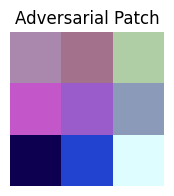

Attack Success Rate: 89.68%


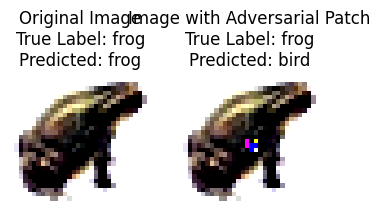

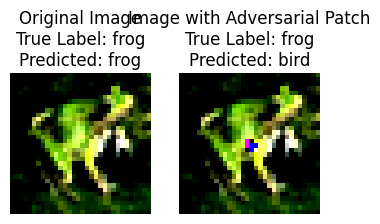

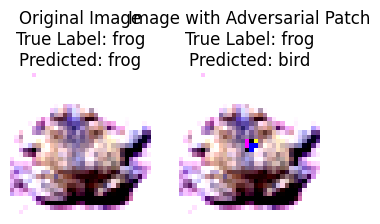

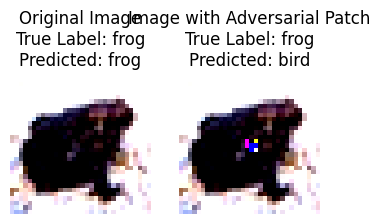

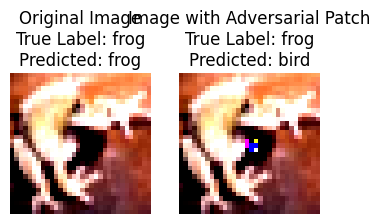


Training for patch size: (5, 5)
Epoch 1/50, Loss: 9.2329
Epoch 2/50, Loss: 7.8476
Epoch 3/50, Loss: 6.0588
Epoch 4/50, Loss: 4.7525
Epoch 5/50, Loss: 4.0605
Epoch 6/50, Loss: 3.7018
Epoch 7/50, Loss: 3.5161
Epoch 8/50, Loss: 3.3693
Epoch 9/50, Loss: 3.2655
Epoch 10/50, Loss: 3.1845
Epoch 11/50, Loss: 3.1398
Epoch 12/50, Loss: 3.0818
Epoch 13/50, Loss: 3.0732
Epoch 14/50, Loss: 3.0458
Epoch 15/50, Loss: 3.0220
Epoch 16/50, Loss: 3.0039
Epoch 17/50, Loss: 2.9945
Epoch 18/50, Loss: 2.9856
Epoch 19/50, Loss: 2.9744
Epoch 20/50, Loss: 2.9660
Epoch 21/50, Loss: 2.9630
Epoch 22/50, Loss: 2.9565
Epoch 23/50, Loss: 2.9390
Epoch 24/50, Loss: 2.9375
Epoch 25/50, Loss: 2.9247
Epoch 26/50, Loss: 2.9226
Epoch 27/50, Loss: 2.9152
Epoch 28/50, Loss: 2.9157
Epoch 29/50, Loss: 2.8966
Epoch 30/50, Loss: 2.9117
Epoch 31/50, Loss: 2.8916
Epoch 32/50, Loss: 2.8975
Epoch 33/50, Loss: 2.8740
Epoch 34/50, Loss: 2.8845
Epoch 35/50, Loss: 2.8708
Epoch 36/50, Loss: 2.8646
Epoch 37/50, Loss: 2.8605
Epoch 38/50, L

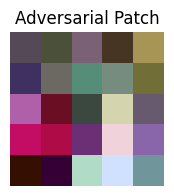

Attack Success Rate: 90.06%


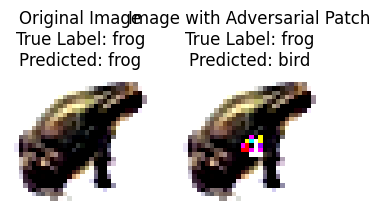

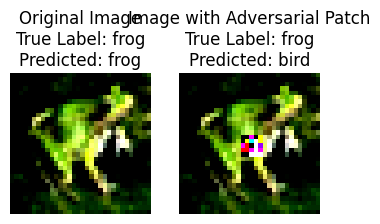

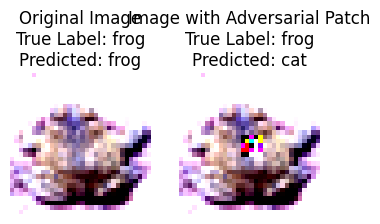

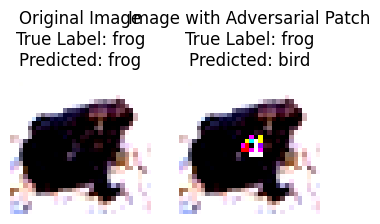

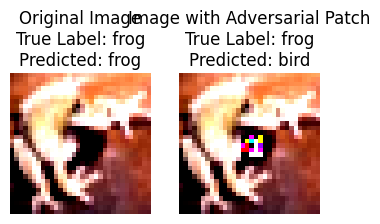


Training for patch size: (7, 7)
Epoch 1/50, Loss: 8.5559
Epoch 2/50, Loss: 7.0439
Epoch 3/50, Loss: 5.6400
Epoch 4/50, Loss: 4.6762
Epoch 5/50, Loss: 4.0016
Epoch 6/50, Loss: 3.5962
Epoch 7/50, Loss: 3.3707
Epoch 8/50, Loss: 3.2137
Epoch 9/50, Loss: 3.1184
Epoch 10/50, Loss: 3.0623
Epoch 11/50, Loss: 3.0217
Epoch 12/50, Loss: 2.9892
Epoch 13/50, Loss: 2.9573
Epoch 14/50, Loss: 2.9237
Epoch 15/50, Loss: 2.9071
Epoch 16/50, Loss: 2.9004
Epoch 17/50, Loss: 2.8921
Epoch 18/50, Loss: 2.8671
Epoch 19/50, Loss: 2.8631
Epoch 20/50, Loss: 2.8347
Epoch 21/50, Loss: 2.8349
Epoch 22/50, Loss: 2.8194
Epoch 23/50, Loss: 2.7973
Epoch 24/50, Loss: 2.7885
Epoch 25/50, Loss: 2.7782
Epoch 26/50, Loss: 2.7705
Epoch 27/50, Loss: 2.7566
Epoch 28/50, Loss: 2.7478
Epoch 29/50, Loss: 2.7365
Epoch 30/50, Loss: 2.7352
Epoch 31/50, Loss: 2.7135
Epoch 32/50, Loss: 2.7063
Epoch 33/50, Loss: 2.6998
Epoch 34/50, Loss: 2.6951
Epoch 35/50, Loss: 2.6914
Epoch 36/50, Loss: 2.6807
Epoch 37/50, Loss: 2.6745
Epoch 38/50, L

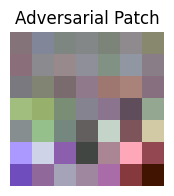

Attack Success Rate: 89.26%


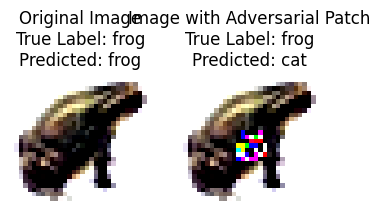

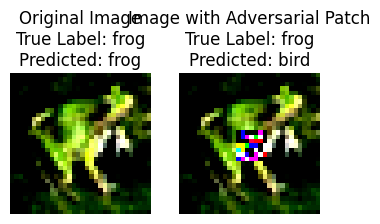

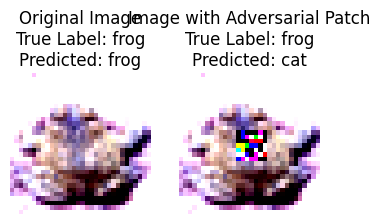

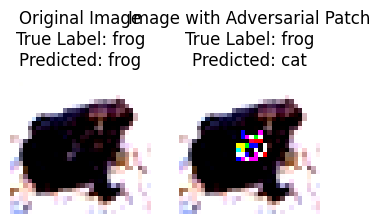

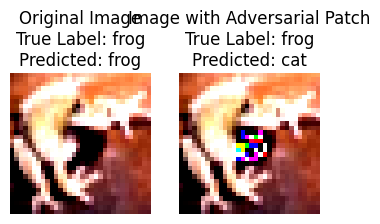


Training for patch size: (16, 16)
Epoch 1/50, Loss: 4.8722
Epoch 2/50, Loss: 3.9268
Epoch 3/50, Loss: 3.5313
Epoch 4/50, Loss: 3.2806
Epoch 5/50, Loss: 3.1099
Epoch 6/50, Loss: 2.9724
Epoch 7/50, Loss: 2.8619
Epoch 8/50, Loss: 2.7924
Epoch 9/50, Loss: 2.7138
Epoch 10/50, Loss: 2.6532
Epoch 11/50, Loss: 2.6100
Epoch 12/50, Loss: 2.5695
Epoch 13/50, Loss: 2.5316
Epoch 14/50, Loss: 2.5128
Epoch 15/50, Loss: 2.4859
Epoch 16/50, Loss: 2.4715
Epoch 17/50, Loss: 2.4565
Epoch 18/50, Loss: 2.4459
Epoch 19/50, Loss: 2.4325
Epoch 20/50, Loss: 2.4228
Epoch 21/50, Loss: 2.4164
Epoch 22/50, Loss: 2.4085
Epoch 23/50, Loss: 2.3977
Epoch 24/50, Loss: 2.3937
Epoch 25/50, Loss: 2.3900
Epoch 26/50, Loss: 2.3846
Epoch 27/50, Loss: 2.3786
Epoch 28/50, Loss: 2.3711
Epoch 29/50, Loss: 2.3713
Epoch 30/50, Loss: 2.3657
Epoch 31/50, Loss: 2.3617
Epoch 32/50, Loss: 2.3620
Epoch 33/50, Loss: 2.3607
Epoch 34/50, Loss: 2.3539
Epoch 35/50, Loss: 2.3541
Epoch 36/50, Loss: 2.3524
Epoch 37/50, Loss: 2.3499
Epoch 38/50,

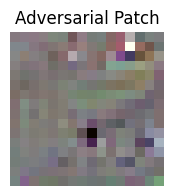

Attack Success Rate: 87.36%


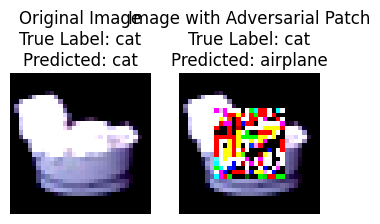

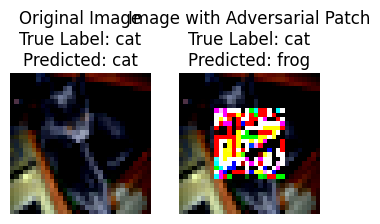

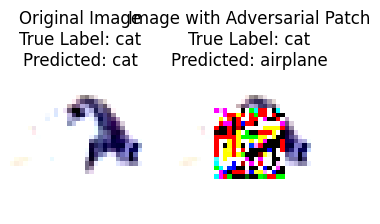

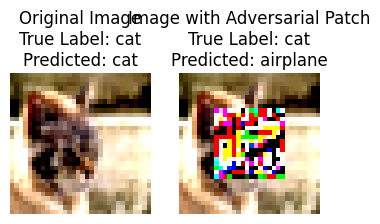

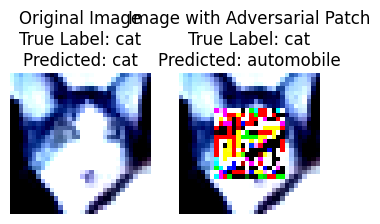

In [ ]:

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Different patch sizes
patch_sizes = [(3, 3), (5, 5), (7, 7), (16, 16)]

# Train and evaluate patches of different sizes
for patch_size in patch_sizes:
    print(f"\nTraining for patch size: {patch_size}")
    patch = create_patch(patch_size)
    train_adversarial_patch(model, patch, target_class=None, num_epochs=50)

    # Save the patch
    torch.save(patch, f'adversarial_patch_{patch_size[0]}x{patch_size[1]}.pth')

    # Visualize the patch
    print(f"Visualizing patch of size {patch_size}")
    visualize_patch(patch)

    # Evaluate attack success rate
    evaluate_patch(model, patch, test_loader)

    # Visualize misclassified examples with the adversarial patch
    visualize_misclassified_patched_images(model, patch, test_loader, classes, num_examples=5)